In [442]:
from radar import *
from rain import *

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import seaborn as sbn
import pandas as pd 
import numpy as np

%matplotlib inline

In [2]:
TOP50 = pd.read_csv('../../Paper/TOP50_Events/TOP50_events_Charlotte.csv', parse_dates=[0,1])

In [212]:
c = Radar('charlotte', TOP50.t_begin[0], how='hdf5', store='TOP50.h5', fname='storm_{yyyy}_{mm:02d}_{dd:02d}', make_rate=4)

In [4]:
from rpy2 import robjects 
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
SpatialVx = importr('SpatialVx')
rsummary = robjects.r.summary

In [402]:
d={}
for i in range(0,96):
    hold = SpatialVx.make_SpatialVx(c.box[i,:,:], c.box[i+1,:,:], loc=ll)
    kwargs ={''}
    look = SpatialVx.FeatureFinder(hold, smoothpar=2, thresh=10, min_size=20)
    
    try:
        x = rsummary(look, silent=True)[0]
    except:
        continue
    px = pandas2ri.ri2py(x)
    df0 = pd.DataFrame(px, columns=['centroidX', 'centroidY', 'area', 'OrientationAngle', 
                                  'AspectRatio', 'Intensity0.25', 'Intensity0.9'])
    df0['Observed'] = list(df0.index+1)
    m = SpatialVx.centmatch(look, criteria=3, const=20)
    p = pandas2ri.ri2py(m[12])
    df1 = pd.DataFrame(p, columns=['Forecast', 'Observed'])
    l = SpatialVx.FeatureMatchAnalyzer(m)
    try:
        p = pandas2ri.ri2py(rsummary(l, silent=True))
    except:
        continue
    df2 = pd.DataFrame(p, columns=['Partial Hausdorff Distance','Mean Error Distance','Mean Square Error Distance',
                                  'Pratts Figure of Merit','Minimum Separation Distance', 'Centroid Distance',
                                  'Angle Difference','Area Ratio','Intersection Area','Bearing', 'Baddeleys Delta Metric',
                                  'Hausdorff Distance'])
    df3 = df1.join(df2)
    
    d.update({c.time[i]: pd.merge(df0, df3, how='outer')})
'''    
for k, v in d.items():
    v['lat']=np.nan
    v['lon']=np.nan
    for i in v.index:
        idX = int(np.round(v.centroidX[i]))
        idY = int(np.round(v.centroidY[i]))
        v.set_value(i, 'lat', c.lat[idX, idY])
        v.set_value(i, 'lon', c.lon[idX, idY])
'''
p = pd.Panel(d)

[1] "No matches found"


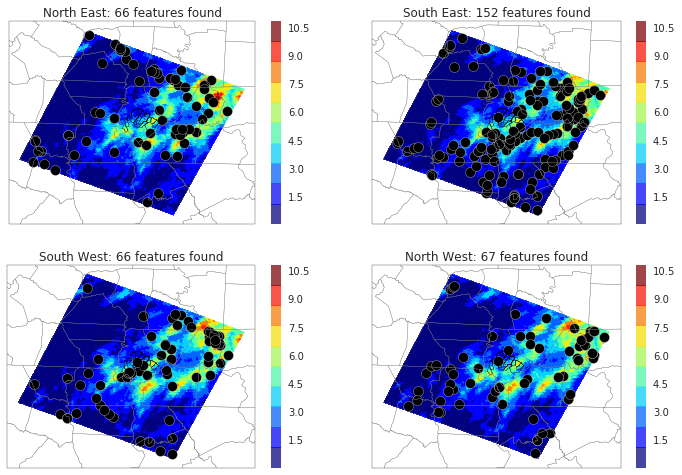

In [443]:
ne = (0, 90, 'North East')
se = (90, 180, 'South East')
sw = (-180, -90, 'South West')
nw = (-90, 0, 'North West')
n=1
plt.figure(figsize=(12,8))
for b in [ne, se, sw, nw]:
    bool_array = (p[:,:,'Bearing']>b[0]) & (p[:,:,'Bearing']<b[1])
    lon=p[:,:,'centroidX'][bool_array].stack().values
    lat=p[:,:,'centroidY'][bool_array].stack().values
    scat, ax = radar_map(c, storm_mean=True, at=[lon, lat], nrows=2, ncols=2, n=n, colors=['black'])
    ax.set_title('{direction}: {k} features found'.format(direction=b[2], k=len(lon)))
    n+=1


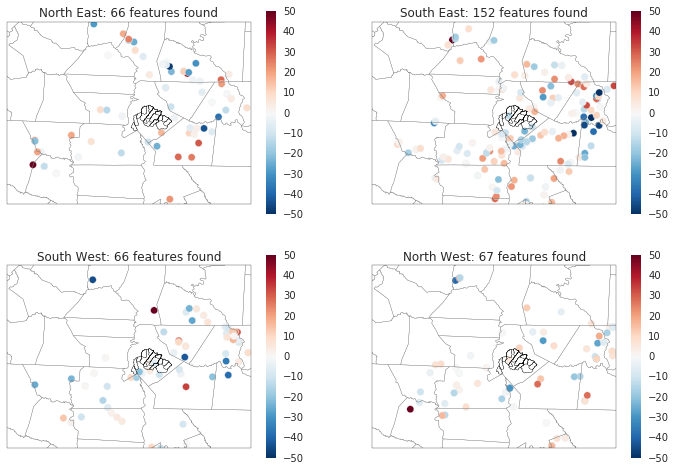

In [447]:
n=1
plt.figure(figsize=(12,8))
for b in [ne, se, sw, nw]:
    bool_array = (p[:,:,'Bearing']>b[0]) & (p[:,:,'Bearing']<b[1])
    lon=p[:,:,'centroidX'][bool_array].stack().values
    lat=p[:,:,'centroidY'][bool_array].stack().values
    j=[]
    ifeats = np.where(bool_array.values)[0]
    its = np.where(bool_array.values)[1]
    for ifeat, it in zip(ifeats, its):
        try:
            nfeat = p[it,ifeat,:].Forecast-1
            j0 = p[it,ifeat,'Intensity0.9']# p[it,ifeat,'area'] * (p[it,ifeat,'Intensity0.25']) + p[it,ifeat,'Intensity0.9'])
            j1 = p[it+1,nfeat,'Intensity0.9'] #* (p[it,nfeat,'Intensity0.25'])# + p[it,nfeat,'Intensity0.9'])
            j.append(j1-j0)
        except:
            j.append(0)
    ax = plt.subplot(2, 2, n, projection=ccrs.PlateCarree())
    ax.add_geometries(basins, ccrs.PlateCarree(), edgecolor='black', facecolor='None')
    ax.add_geometries(county, ccrs.PlateCarree(), edgecolor='gray', facecolor='None')
    ax.set_extent(large_extent, ccrs.PlateCarree())
    scat = ax.scatter(x=lon, y=lat, c=j,s=50, vmin=-50, vmax=50, cmap='RdBu_r')
    plt.colorbar(scat, ax=ax)
    ax.set_title('{direction}: {k} features found'.format(direction=b[2], k=len(lon)))
    n+=1

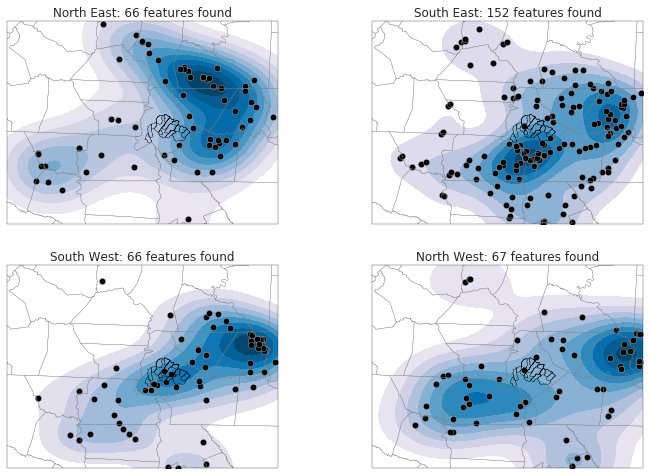

In [450]:
plt.figure(figsize=(12,8))
n=1
for b in [ne, se, sw, nw]:
    bool_array = (p[:,:,'Bearing']>b[0]) & (p[:,:,'Bearing']<b[1])
    lon=p[:,:,'centroidX'][bool_array].stack().values
    lat=p[:,:,'centroidY'][bool_array].stack().values

    ax = plt.subplot(2, 2, n, projection=ccrs.PlateCarree())
    ax.add_geometries(basins, ccrs.PlateCarree(), edgecolor='black', facecolor='None')
    ax.add_geometries(county, ccrs.PlateCarree(), edgecolor='gray', facecolor='None')
    ax.set_extent(large_extent, ccrs.PlateCarree())
    sns.kdeplot(np.array([lon,lat]).T, shade=True, cmap="PuBu", ax=ax)
    ax.patch.set_facecolor('white')
    ax.collections[0].set_alpha(0)
    ax.scatter(x=lon, y=lat, s=40, c='black')
    ax.set_title('{direction}: {k} features found'.format(direction=b[2], k=len(lon)))
    n+=1

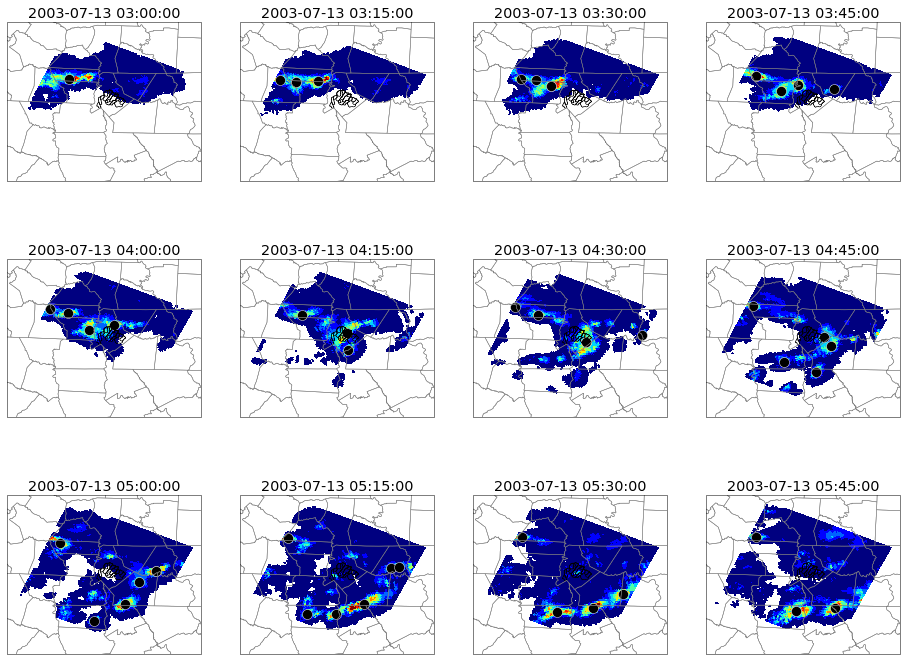

In [204]:
plt.figure(figsize=(16, 12))
n=1
for i in range(60,72):
    c.t = c.time[i]
    scat, ax = radar_map(c, feat=True, nrows=3, ncols=4, n=n)
    n+=1

In [365]:
%matplotlib inline
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import pandas as pd 
import numpy as np

large_extent = [-82, -80, 34.5, 36]
small_extent = [-81.035000-.01, -80.552222+.01, 35.019722-.01, 35.507778+.01]

fname = '../../data/CHARLOTTE/Maps/new_basin.shp'
basins = list(shpreader.Reader(fname).geometries())

fname = '../../data/CHARLOTTE/Maps/county.shp'
county = list(shpreader.Reader(fname).geometries())

cmap = plt.cm.get_cmap('jet', 10)
cmap.set_under(color='None')


def radar_map(radar, feat=False, save=False, storm_mean=False, t_end=None, nrows=1, ncols=1, n=1, **kwargs):
    ax = plt.subplot(nrows, ncols, n, projection=ccrs.PlateCarree())

    ax.set_title(radar.t)
    i = radar.time.get_loc(radar.t)
    ax.add_geometries(basins, ccrs.PlateCarree(), edgecolor='black', facecolor='None')
    ax.add_geometries(county, ccrs.PlateCarree(), edgecolor='gray', facecolor='None')
    #ax.set_extent(small_extent, ccrs.PlateCarree())
    
    if storm_mean:
        scat = ax.pcolor(radar.lon, radar.lat, radar.box.mean(0),cmap=cmap, alpha=.7)
        plt.colorbar(scat, fraction=0.05)
    else:
        scat = ax.pcolor(radar.lon, radar.lat, radar.box[i,:,:], vmin=.1, vmax=100, cmap=cmap)
    if feat:
        try:
            #ax.scatter(p[radar.t].lon, p[radar.t].lat, c='black',s=200)
            ax.scatter(p[radar.t].centroidX, p[radar.t].centroidY, c='black',s=100)
        except:
            print 'no features found'
            pass
    if 'at' in kwargs:
        if 'colors' in kwargs:
            color=kwargs['colors']
        else:
            color='black'
        ax.scatter(x=kwargs['at'][0], y=kwargs['at'][1], c=color,s=100)
    return(scat, ax)